# Spotify Playlist Recommendation System

- In Spotify's apps, music can be browsed or searched for via various parameters, such as artist,
album, genre, playlist, or record label. Users can create, edit and share playlists,
share tracks on social media, and make playlists with other users. 
Spotify provides access to over 70 million songs, 2.2 million podcasts and 4 billion playlists.

- As a popular music streaming service, it is used by a large number of people all over the world 
on a daily basis. One way in which Spotify keeps its users not only s
atisfied with, but also hooked to the platform, is by making smart and 
personal recommendations to users based on their listening history.

- In this notebook, I will be developing a Colaborative Filttering recommendation system for Spotify
Using Colaborative Filttering

### Importing Pakages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import shutil
from pandas.io.json import json_normalize
import sys, re, json, os, datetime
import spotipy
import warnings
warnings.filterwarnings('ignore')

from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
%matplotlib inline

import seaborn as sns
sns.set()
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [2]:
import json
# reading the json files and concatenating them in one dataframe
data1= json.load(open('mpd.slice.0-999.json'))
data2= json.load(open('mpd.slice.1000-1999.json'))
data3= json.load(open('mpd.slice.2000-2999.json'))
data4= json.load(open('mpd.slice.3000-3999.json'))
df1= pd.DataFrame(data1['playlists'])
df2= pd.DataFrame(data2['playlists'])
df3= pd.DataFrame(data3['playlists'])
df4= pd.DataFrame(data4['playlists'])
df= pd.concat([df1, df2, df3, df4], axis=0)
df= df.explode('tracks')
df= pd.concat([df.drop(['tracks'], axis=1), df['tracks'].apply(pd.Series)],axis=1)
# renaming the columns with the same name
df.columns=['name', 'collaborative', 'pid', 'modified_at', 'num_tracks',
       'num_albums', 'num_followers', 'num_edits', 'playlist_duration_ms',
       'num_artists', 'description', 'pos', 'artist_name', 'track_uri',
       'artist_uri', 'track_name', 'album_uri', 'track_duration_ms',
       'album_name']

In [3]:
df.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,track_duration_ms,album_name
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


In [6]:
#extract uri 
df['track_uri']= df["track_uri"].apply(lambda x: re.findall(r'\w+$', str(x))[0])

In [7]:
df.shape

(266386, 19)

In [8]:
df['artist_name'].value_counts()

Drake                     3429
Kanye West                1473
The Weeknd                1329
Kendrick Lamar            1307
Rihanna                   1258
                          ... 
RINSE                        1
Youth Group                  1
The Manhattan Transfer       1
Movie Favorites              1
A$Ap Ant                     1
Name: artist_name, Length: 22051, dtype: int64

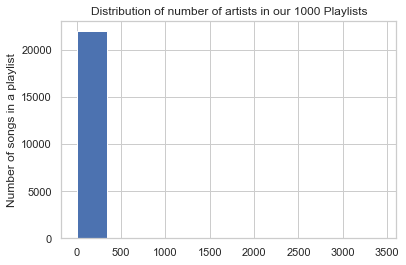

In [10]:
plt.hist(df['artist_name'].value_counts())
plt.title("Distribution of number of artists in our 1000 Playlists")
plt.ylabel("Count")
plt.ylabel("Number of songs in a playlist")
plt.show()

In [11]:
df.dtypes

name                    object
collaborative           object
pid                      int64
modified_at              int64
num_tracks               int64
num_albums               int64
num_followers            int64
num_edits                int64
playlist_duration_ms     int64
num_artists              int64
description             object
pos                      int64
artist_name             object
track_uri               object
artist_uri              object
track_name              object
album_uri               object
track_duration_ms        int64
album_name              object
dtype: object

In [12]:
df.isnull().sum()

name                         0
collaborative                0
pid                          0
modified_at                  0
num_tracks                   0
num_albums                   0
num_followers                0
num_edits                    0
playlist_duration_ms         0
num_artists                  0
description             261053
pos                          0
artist_name                  0
track_uri                    0
artist_uri                   0
track_name                   0
album_uri                    0
track_duration_ms            0
album_name                   0
dtype: int64

In [13]:
df.drop('description' ,axis = 1, inplace = True)

In [14]:
df.isnull().sum()

name                    0
collaborative           0
pid                     0
modified_at             0
num_tracks              0
num_albums              0
num_followers           0
num_edits               0
playlist_duration_ms    0
num_artists             0
pos                     0
artist_name             0
track_uri               0
artist_uri              0
track_name              0
album_uri               0
track_duration_ms       0
album_name              0
dtype: int64

In [15]:
#make sure no repeat of songs
df['track_name'].value_counts()

Closer                       299
Home                         205
Ride                         182
Roses                        178
HUMBLE.                      178
                            ... 
Never Forget Me                1
Were My Dogs At                1
Shit Dont Change               1
56 Bars                        1
Close To Me - Closest Mix      1
Name: track_name, Length: 75833, dtype: int64

In [16]:
df['artist_name'].value_counts()

Drake                     3429
Kanye West                1473
The Weeknd                1329
Kendrick Lamar            1307
Rihanna                   1258
                          ... 
RINSE                        1
Youth Group                  1
The Manhattan Transfer       1
Movie Favorites              1
A$Ap Ant                     1
Name: artist_name, Length: 22051, dtype: int64

## Spotify Web API Call

In [17]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#Connecting spotify api 
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="fbb3360236864048b74c63b8964c7fe5",
                                                        client_secret="370784cc2d4d47b88c4700e0ecd4a0d6"))

In [18]:
track = df['track_uri'].values.tolist()
len(track)

266386

In [20]:
#Extracting audio feature in the batch of 100 and saving as csv
f = open('audio_features.csv','a')
for i in range(0,len(track),100):
    track_feature = sp.audio_features(track[i:i+100])
    track_df = pd.DataFrame(track_feature)
    csv_data = track_df.to_csv(header=False,index=False)
    f.write(csv_data)

f.close()

In [21]:
#Getting the colums of audio features
track_feature = sp.audio_features(track[0])
track_feature = pd.DataFrame(track_feature)
track_feature_col = track_feature.columns

audio_ft = pd.read_csv('audio_features.csv',names=track_feature_col)
audio_ft.shape

(266386, 18)

In [22]:
audio_ft.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


In [38]:
#audio_ft.to_csv('Spotify_data.csv')

In [27]:
#Drop uri and duration
audio_ft.drop('uri',axis=1 ,inplace=True)
audio_ft.drop('duration_ms',axis=1 ,inplace=True)

In [29]:
df.shape

(266386, 18)

In [30]:
audio_ft.shape

(266386, 16)

In [31]:
df = df.reset_index() #Resetting index to concat 
All_data = pd.concat([df,audio_ft],axis=1)

In [32]:
All_data.head()

,index,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,pos,artist_name,track_uri,artist_uri,track_name,album_uri,track_duration_ms,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,time_signature
0,0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,4
1,0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,4
2,0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,4
3,0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,4
4,0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,4,Shaggy,1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,4


In [33]:
All_data.shape

(266386, 35)

## Audio Features Explanation

- acousticness ==> confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- danceability ==> measure describes how suitable a track is for dancing.
- energy ==> represents a perceptual measure of intensity and activity.
- instrumentalness ==> predicts whether a track contains vocals or not.
- loudness ==> of a track in decibels(dB).
- liveness ==> detects the presence of an audience in the recording.
- speechiness detects the presence of spoken words in a track.
- time_signature ==> is an estimated overall time signature of a track.
- key ==> the track is in. Integers map to pitches using standard Pitch Class notation.
- valence ==> measures from 0.0 to 1.0 describing the musical positiveness (vibe) conveyed by a track.
- tempo ==> is in beats per minute (BPM).
- mode (Melody) indicates the modality(major or minor) of the song.

## Data

In [40]:
data = pd.read_csv('Spotify_data.csv')

In [41]:
data.head()

,Unnamed: 0,index,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,pos,artist_name,track_uri,artist_uri,track_name,album_uri,track_duration_ms,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,time_signature
0,0,0,Throwbacks,False,0,1493424000,52,47,1,6,11532414,37,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,4
1,1,0,Throwbacks,False,0,1493424000,52,47,1,6,11532414,37,1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,4
2,2,0,Throwbacks,False,0,1493424000,52,47,1,6,11532414,37,2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,4
3,3,0,Throwbacks,False,0,1493424000,52,47,1,6,11532414,37,3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,4
4,4,0,Throwbacks,False,0,1493424000,52,47,1,6,11532414,37,4,Shaggy,1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,4


## EDA

In [43]:
data.describe()

,Unnamed: 0,index,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,pos,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,266386.000000,266386.000000,266386.000000,2.663860e+05,266386.000000,266386.000000,266386.000000,266386.000000,2.663860e+05,266386.000000,266386.000000,2.663860e+05,266386.000000,266386.000000,266386.000000,266386.000000,266386.000000,266386.000000,266386.000000,266386.000000,266386.000000,266386.000000,266386.000000,266386.000000
mean,133192.500000,501.060029,1993.841182,1.481416e+09,109.696118,78.485273,2.587058,28.414714,2.569005e+07,58.080781,54.348059,2.341668e+05,0.606072,0.647333,5.186331,-7.206658,0.662997,0.093197,0.230183,0.054500,0.189562,0.493618,121.673993,3.945057
std,76899.158742,289.072876,1154.302420,3.413926e+07,62.854489,47.731695,41.220510,28.720508,1.508847e+07,36.989759,48.162079,7.358286e+04,0.159368,0.208262,3.616253,3.572826,0.472687,0.099527,0.273575,0.183956,0.155598,0.239470,28.733013,0.332745
min,0.000000,0.000000,0.000000,1.322611e+09,5.000000,2.000000,1.000000,2.000000,9.238790e+05,3.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66596.250000,251.000000,986.000000,1.466467e+09,57.000000,40.000000,1.000000,7.000000,1.310109e+07,30.000000,17.000000,1.982930e+05,0.501000,0.514000,2.000000,-8.628000,0.000000,0.035600,0.020800,0.000000,0.094400,0.304000,99.539000,4.000000
50%,133192.500000,499.000000,1982.000000,1.495843e+09,100.000000,71.000000,1.000000,18.000000,2.330853e+07,51.000000,40.000000,2.248660e+05,0.614000,0.676000,5.000000,-6.454000,1.000000,0.050100,0.104000,0.000003,0.126000,0.486000,120.529000,4.000000
75%,199788.750000,755.000000,2998.000000,1.506989e+09,157.000000,110.000000,2.000000,39.000000,3.621352e+07,78.000000,79.000000,2.586260e+05,0.721000,0.811000,8.000000,-4.880000,1.000000,0.101000,0.357000,0.000732,0.241000,0.680000,139.995000,4.000000
max,266385.000000,999.000000,3999.000000,1.509494e+09,248.000000,233.000000,2699.000000,178.000000,7.997390e+07,199.000000,247.000000,5.279768e+06,0.991000,1.000000,11.000000,2.766000,1.000000,0.962000,0.996000,0.999000,1.000000,1.000000,232.080000,5.000000


In [44]:
data.isnull().sum()

Unnamed: 0              0
index                   0
name                    0
collaborative           0
pid                     0
modified_at             0
num_tracks              0
num_albums              0
num_followers           0
num_edits               0
playlist_duration_ms    0
num_artists             0
pos                     0
artist_name             0
track_uri               0
artist_uri              0
track_name              0
album_uri               0
track_duration_ms       0
album_name              0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
type                    0
id                      0
track_href              0
analysis_url            0
time_signature          0
dtype: int64

In [47]:
data.drop(['track_uri','album_uri', 'artist_uri', 'album_name', 'track_href', 'analysis_url', 'pos', 'type', 'index'], inplace=True, axis=1)


In [57]:
data.drop(['pid', 'time_signature'],inplace=True, axis=1)

In [61]:
data.head(2)

,Unnamed: 0,name,collaborative,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,artist_name,track_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,Throwbacks,False,1493424000,52,47,1,6,11532414,37,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),226863,0.904,0.813,4,-7.105,0,0.121,0.0311,0.00697,0.0471,0.810,125.461
1,1,Throwbacks,False,1493424000,52,47,1,6,11532414,37,Britney Spears,Toxic,198800,0.774,0.838,5,-3.914,0,0.114,0.0249,0.02500,0.2420,0.924,143.040


In [51]:
data.reset_index(drop=True, inplace=True)

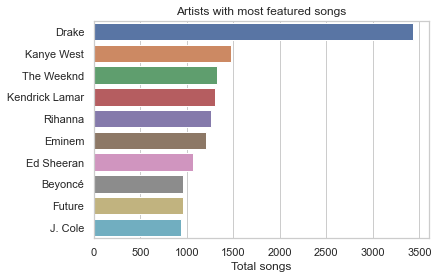

In [62]:
# Checking which artists are featured most across sampled dataset
values = list(data['artist_name'].value_counts())
names = data['artist_name'].value_counts().index.tolist()
ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs')
ax.set_xlabel('Total songs');

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'modified_at'}>,
        <AxesSubplot:title={'center':'num_tracks'}>,
        <AxesSubplot:title={'center':'num_albums'}>],
       [<AxesSubplot:title={'center':'num_followers'}>,
        <AxesSubplot:title={'center':'num_edits'}>,
        <AxesSubplot:title={'center':'playlist_duration_ms'}>,
        <AxesSubplot:title={'center':'num_artists'}>],
       [<AxesSubplot:title={'center':'track_duration_ms'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'key'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'acousticness'}>],
       [<AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'ce

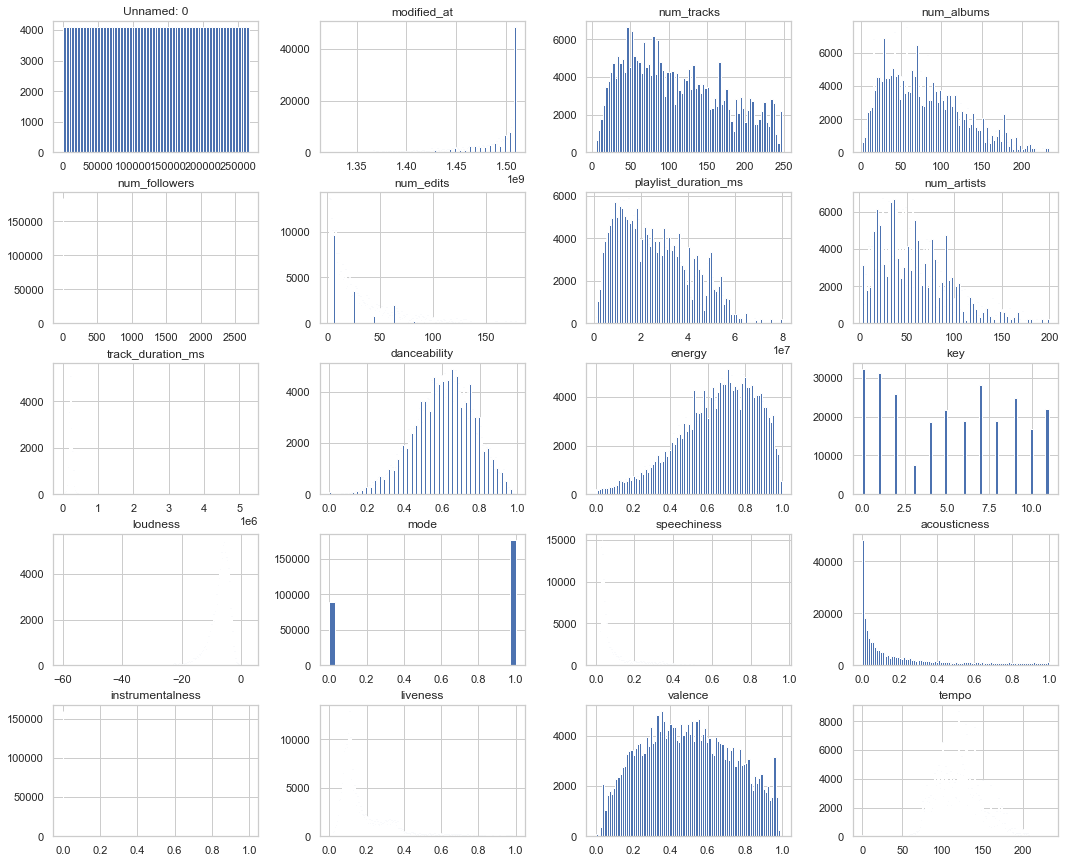

In [64]:
data.hist(figsize=(18,15), bins='auto')

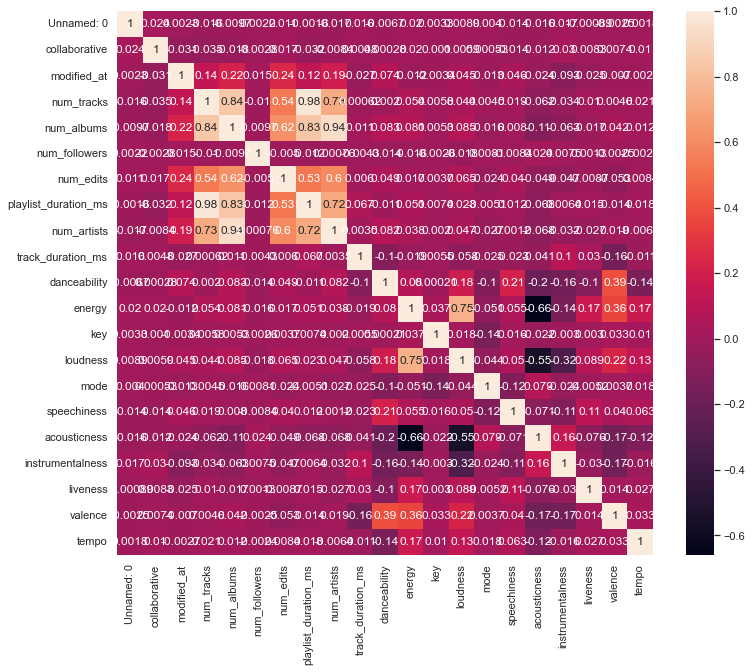

In [65]:
###get Corr between Features
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True)
plt.show()
#plt.savefig('correlation.jpg', bbox_inches='tight')

## Data Preparation

Due to one of my models being based on cosine similarity, I will scale the audio (sound) features being and
reframe the DataFrame to dispaly metadata for each track first and audio features last.

In [67]:
sound_features = data[['danceability', 'valence', 'loudness', 'energy']]

mdata = data.drop(['danceability', 'valence', 'loudness', 'energy'], axis = 1)

In [68]:
sound_features.head()

,danceability,valence,loudness,energy
0,0.904,0.810,-7.105,0.813
1,0.774,0.924,-3.914,0.838
2,0.664,0.701,-6.583,0.758
3,0.892,0.817,-6.055,0.714
4,0.853,0.654,-4.596,0.606


In [70]:
#Scale the sound-specific features and organize them in a new DataFrame
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

sound_features2 = pd.DataFrame()

for col in sound_features.columns:    
    
    sound_features2[col] = scaler.fit_transform(sound_features[col].values.reshape(-1,1)).ravel()

In [75]:
sound_features2.head()

,danceability,valence,loudness,energy
0,0.912210,0.810,0.842733,0.813
1,0.781029,0.924,0.893573,0.838
2,0.670030,0.701,0.851050,0.758
3,0.900101,0.817,0.859462,0.714
4,0.860747,0.654,0.882707,0.606


In [72]:
metadatafeat = mdata.join(sound_features2)

In [74]:
metadatafeat.head()

,Unnamed: 0,name,collaborative,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,artist_name,track_name,track_duration_ms,key,mode,speechiness,acousticness,instrumentalness,liveness,tempo,danceability,valence,loudness,energy
0,0,Throwbacks,False,1493424000,52,47,1,6,11532414,37,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),226863,4,0,0.1210,0.03110,0.006970,0.0471,125.461,0.912210,0.810,0.842733,0.813
1,1,Throwbacks,False,1493424000,52,47,1,6,11532414,37,Britney Spears,Toxic,198800,5,0,0.1140,0.02490,0.025000,0.2420,143.040,0.781029,0.924,0.893573,0.838
2,2,Throwbacks,False,1493424000,52,47,1,6,11532414,37,Beyoncé,Crazy In Love,235933,2,0,0.2100,0.00238,0.000000,0.0598,99.259,0.670030,0.701,0.851050,0.758
3,3,Throwbacks,False,1493424000,52,47,1,6,11532414,37,Justin Timberlake,Rock Your Body,267266,4,0,0.1410,0.20100,0.000234,0.0521,100.972,0.900101,0.817,0.859462,0.714
4,4,Throwbacks,False,1493424000,52,47,1,6,11532414,37,Shaggy,It Wasn't Me,227600,0,1,0.0713,0.05610,0.000000,0.3130,94.759,0.860747,0.654,0.882707,0.606


## Label Encoding

In [79]:
encoder = LabelEncoder()

In [80]:
# convert categorical data to numberical data on training data
data = data.apply(encoder.fit_transform)

In [81]:
data.head()

,Unnamed: 0,name,collaborative,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,artist_name,track_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,1683,0,1010,47,45,0,4,1999,34,13184,38203,21250,985,1661,4,11787,0,799,3015,3286,291,1460,27114
1,1,1683,0,1010,47,45,0,4,1999,34,2657,66818,13708,855,1686,5,14978,0,792,2953,3734,962,1574,35799
2,2,1683,0,1010,47,45,0,4,1999,34,2000,13383,23438,745,1606,2,12309,0,888,2042,0,418,1351,13883
3,3,1683,0,1010,47,45,0,4,1999,34,9941,52418,29585,973,1562,4,12837,0,819,3805,1930,341,1467,14719
4,4,1683,0,1010,47,45,0,4,1999,34,16862,32569,21440,934,1454,0,14296,1,491,3265,0,1033,1304,11498


# Models

In [82]:
# a helper func
def get_index_from_name(name):
    '''
    This function returns the index of the row when given a song name
    '''
    return metadatafeat[metadatafeat["track_name"]==name].index.tolist()[0]

### Model : Cosine Similarity by audio features

In [95]:
def recomend_songs_by_audio_similarity(data, song, artist):
    
    try: 
        track_and_artist_data = data[(data['track_name'] == song) & (data["artist_name"]== artist)]

        similar_songs = data.copy()

        audio_properties = similar_songs.loc[:,['danceability', 'valence', 'loudness', 'energy']]

        #Calculate similiary of all songs to the one we want
        similar_songs['Similarity with song'] = cosine_similarity(audio_properties, audio_properties.to_numpy()[track_and_artist_data.index[0],None]).squeeze()

        similar_songs.rename(columns={'track_name': f'Songs Similar to {song}'}, inplace=True)

        similar_songs = similar_songs.sort_values(by= 'Similarity with song', ascending = False)

        similar_songs = similar_songs[['artist_name', f'Songs Similar to {song}',
          'danceability', 'energy', 'loudness', 'valence']]

        similar_songs.reset_index(drop=True, inplace=True)

        return similar_songs.iloc[0:12]
    
    except:
        print("Unfortunately, this song is not included in our dataset")

In [96]:
recomend_songs_by_audio_similarity(metadatafeat, "Magnolia", "Playboi Carti")

,artist_name,Songs Similar to Magnolia,danceability,energy,loudness,valence
0,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
1,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
2,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
3,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
4,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
5,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
6,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
7,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
8,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443
9,Playboi Carti,Magnolia,0.798184,0.582,0.83926,0.443


In [97]:
recomend_songs_by_audio_similarity(metadatafeat, "My Time", "Fabolous")

,artist_name,Songs Similar to My Time,danceability,energy,loudness,valence
0,Fabolous,My Time,0.600404,0.819,0.857375,0.498
1,Fabolous,My Time,0.600404,0.819,0.857375,0.498
2,Parker McCollum,Who's Laughing Now,0.586276,0.803,0.844422,0.487
3,Glee Cast,Extraordinary Merry Christmas (Glee Cast Version),0.619576,0.838,0.879553,0.507
4,Glee Cast,Extraordinary Merry Christmas (Glee Cast Version),0.619576,0.838,0.879553,0.507
5,Serena Ryder,What I Wouldn't Do,0.624622,0.841,0.885001,0.517
6,Rivaz,Tell Me Twice (Ultra Music Festival Anthem) - ...,0.642785,0.865,0.907004,0.529
7,Mariah Carey,Your Girl,0.624622,0.852,0.882898,0.512
8,Flipsyde,U.S. History,0.622603,0.861,0.892203,0.522
9,Flame,Joyful Noise,0.628658,0.843,0.888618,0.512


Observations ==> These recommendations seem mostly accurate except for a few out of sorts.

They all sound quite similar to each other, when you listen to them.

In [99]:
Recc1 = recomend_songs_by_audio_similarity(metadatafeat, "Magnolia", "Playboi Carti")
Recc1 = recomend_songs_by_audio_similarity(metadatafeat, "Magnolia", "Playboi Carti")[Recc1.columns[0:2]]

In [100]:
Recc1.columns = ['Artist Name', 'Track']

In [101]:
Recc1 = Recc1[['Track', 'Artist Name']]

Created a separate DataFrame for my first recommendation model result that can be joined with the other 3 later.

In [102]:
Recc1 = pd.DataFrame(Recc1, columns =['Track', 'Artist Name'])
Recc1['Cosine Similarity'] = Recc1['Track'].str.cat(Recc1['Artist Name'],sep=" by: ")
Recc1 = Recc1.iloc[:,-1:]